# Darija Comments Labeling 

This notebook implements an semi-automated labeling system for Moroccan Arabic (Darija) YouTube comments. We use a combination of arijaBERT-arabizi model and machine learning (K-Means) approaches to assign sentiment labels to the comments.

## 1. Setup and Data Loading
In this section, we:
- Set up the working environment
- Install required dependencies
- Load the scraped comments dataset

In [1]:
import os 
os.chdir('/kaggle/input') 
current_directory = os.getcwd()
print("Current working directory:", current_directory)
contents = os.listdir()
print("Directory contents:", contents)
file = "scaped_comments.csv"

Current working directory: /kaggle/input
Directory contents: ['suf_pref_darija.json', 'stop_words_accum.json', 'set2.csv', 'set7.csv', 'set5.csv', 'darija_latin_ref.json', 'set4.csv', 'scaped_comments.csv', 'set3.csv', 'cleaned_clustered_data.csv', 'set1.csv']


In [2]:
!pip install transformers scikit-learn torch 
!pip install pandas PyArabic Tashaphyne pydoda Arabic-Stopwords seaborn scikit-learn emoji xgboost 
!pip install modin[ray]
!pip install ipywidgets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found 

In [3]:
os.environ["MODIN_ENGINE"] = "ray" 
import modin.pandas as pd
import ray
ray.init()

2024-12-06 22:41:43,250	INFO worker.py:1753 -- Started a local Ray instance.


Python version:,3.10.14
Ray version:,2.24.0


In [4]:
import seaborn as sns 
import matplotlib.pyplot as plt
import re
from tashaphyne.stemming import ArabicLightStemmer
import json

## 2. Data Preprocessing
Before labeling, we prepare our data by:
- Cleaning and normalizing text
- Handling special characters and emojis
- Converting Arabizi to Arabic script
- Removing noise and irrelevant content

In [5]:
data = pd.read_csv(file)
data.dropna(inplace=True)
data.head()

,text
0,اش هاذ الخرا من المديعة للضيف الكمرا مان للمشا...
1,بقا فيا هد خينا باينة فيه دوز العداب الله يرد ...
2,لازم حماية هشام.وهادشي خاصو يحبس وسخو بلادنا ب...
3,هههههه صحاب الصحابة الفاشلة
4,مسكين مخلوع عندك غير يديرو ليه شي فضيحة


In [6]:
darija_alphabet = {
    "gh": "غ",
    "sh": "ش",
    "ch": "ش",
    "ss": "س",
    "kh": "خ",
    "ç": "س",
    "ou": "و",    
    "ei": "ي",    
    "ay": "ي",    
    "ae": "ي",   
    "5": "خ",     
    "2": "ا",    
    "b": "ب",
    "t": "ت",
    "j": "ج",
    "7": "ح",
    "d": "د",
    "r": "ر",
    "z": "ز",
    "s": "س",
    "9": "ق",
    "3": "ع",
    "4": "غ",
    "f": "ف",
    "q": "ك",
    "k": "ك",
    "l": "ل",
    "m": "م",
    "n": "ن",
    "h": "ه",
    "w": "و",
    "y": "ي",
    "g": "ڭ",
    'i': 'ي',
    'ee': 'ي',
    'aa': 'ا',
    'oo': 'و',
    'o': 'و',
    "x": "ش",
}
word_in = [
    "ء", "أ", "إ", "آ", "ؤ", "ئ", "ة", "ى","-", "/", ".", "،", '"', "'", "\\", "?", "؟", "!", "،", "؛",":","#", "@", "&", "=", "¥", "$", "%", "*", "+", "<", ">", "|", "~", "^", 
    "\n", "\t", "\r", " و","ذ", "ظ", "ض", "ص","(", ")", "[", "]", "{", "}", "《", "》", "«", "»"
]

replaced_by = [
    "ا", "ا", "ا", "ا", "ا", "ا", "ه", "ي"," ", "", "", "", "", "", "", " ? ", " ؟ ", " ! ", "", "", "",
    "", "", "", "", "", "", "", "", "", "", "", "", "", ""," ", " ", " ", "",
    "د", "د", "د", "س","", "", "", "", "", "", "", "", "", ""
]

arabic_alphabet = "ابتثجحخدذرزسشصضطظعغفقكلمنهوي"

In [7]:
from pyarabic.araby import strip_diacritics
#remove tashkeel
def removing_tashkeel(word): # useed
          return strip_diacritics(word)

In [8]:
from pyarabic.araby import strip_tatweel

#remove tatweel l2imdad
def removing_tatweel(word): # useed
          return strip_tatweel(word)

In [9]:
from pyarabic.araby import normalize_ligature

#remove ligature hamza , alef 
def removing_ligature(word): # not used 
          return normalize_ligature(word)

In [10]:
# remove underscore
def replace_underscore(word): # useed
          return word.replace("_", " ")

In [11]:
import pyarabic.araby as araby

# remove hamza ambiguity
def remove_ambiguity_hamza(word): # useed
          return araby.normalize_hamza(word)

In [12]:
# romove "AL"
def remove_AL(word): # useed
          return re.sub(r'^ال', '', word)

In [13]:
# remove repeated characters      
def word_remover(word): # useed
            if len(word) == 1 or len(word) == 0 or len(word) >= 13:
                return ""                
            else :
                # print(word)
                for a7rf in arabic_alphabet:
                    if a7rf == 'د' or a7rf == 'ه':
                        word = re.sub(fr'{a7rf}{{3,}}', a7rf * 2, word).strip()
                    else:
                        word = re.sub(fr'{a7rf}+', a7rf, word).strip()
                try:
                    for i in range(len(word)):
                        if word[i] in word_in:
                            index = word_in.index(word[i])
                            word = word[:i] + replaced_by[index] + word[i + 1:]
                except IndexError :
                    pass

                return word


In [14]:
# remove url  
def remove_url(text): # useed
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b',
                  '', text, flags=re.MULTILINE)
    return text      
 

In [15]:
 # remove emails     
def remove_emails(text): # useed
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text, flags=re.MULTILINE)
    return text  

In [16]:
def special_tags_and_ponctuations(text):  # Function to clean special tags
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'&quot;', '', text)  
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\.+', '.', text)

    return text

In [17]:
def remove_html_tags(text):
    text = re.sub(r'<[^>]+>', '', text)
    return text

In [18]:
import emoji 
# hundle emojis
def extend_spletting(items):  # helper function to split items
    spletting = []
    for item in items:
        spletting.extend(item.split())
    return spletting

In [19]:
def emoji_hundler(word):  # helper function to handle emojis
    word = emoji.demojize(word, language='ar')
    word = replace_underscore(word)[1:-1]
    return word

In [20]:
def is_an_emoji(word):
    emoji_pattern = re.compile("["  
                               u"\U0001F680-\U0001F6FF"  # transport and map unicods
                               u"\U0001F1E0-\U0001F1FF"  # flags unicods
                               "]+", flags=re.UNICODE)

    if emoji.is_emoji(word):
        word = emoji_pattern.sub(r'', word)
        return extend_spletting([emoji_hundler(word)])

    elif emoji.purely_emoji(word):
        data_of_emojis = emoji.distinct_emoji_list(word)
        data = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        return extend_spletting(data)

    else:
        text_only = re.sub(r'[^\w\s?!]', '', word)
        data_of_emojis = emoji.distinct_emoji_list(word)
        emojis = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        
        return [text_only] + extend_spletting(emojis)


In [21]:
# tramslaing darija(latin) to daruja(arabic)
def translate_darija_to_arabic(word): # useed
    # print("test")
    word = word.lower()
    if  bool(re.compile(r"[a-z0-9']+").search(word)):
        arabic_word = ""
        i = 0
        while i < len(word):
            # print('sadd')
            if i + 1 < len(word) and word[i:i+2] in darija_alphabet: # Check for 2 lettrs
                arabic_word += darija_alphabet[word[i:i+2]]
                i += 2
            elif word[i] in darija_alphabet:
                arabic_word += darija_alphabet[word[i]]
                i += 1
            else:
                i += 1
        return arabic_word
    return word
      

In [22]:
# remove  number arabic and latin

def number_remov(listy): # useed
    number_pattern = re.compile(r'^[0-9\u0660-\u0669]+$')
    cleaned_list = [item for item in listy if not number_pattern.fullmatch(item)] 
    return cleaned_list   

In [23]:
#stemming arabic words     
def stemming_darija(word):
    # file = "./Data_prep/suf_pref_darija.json" # local run
    file = "suf_pref_darija.json" 

    with open(file, 'r', encoding='utf-8') as json_file:
        suf_pref = json.load(json_file)

    ArListem = ArabicLightStemmer()
    ArListem.set_prefix_list(suf_pref['darija_prefixes'])
    ArListem.set_suffix_list(suf_pref['darija_suffixes'])
    ArListem.light_stem(word)  
    return ArListem.get_stem() 

In [24]:
# "03:44"
def remove_yt_timers(text):
    pattern = r'\b\d{1,2}:\d{2,3}(:\d{2,3})?\b'
    text = re.sub(pattern, '', text)
    return text.strip()

In [25]:

def preproc_arab_sentence(word): # main function for  arab processing
    word = removing_tashkeel(word)
    word = removing_tatweel(word)
    word = remove_AL(word)
    # word = remove_ambiguity_hamza(word)
    word = word_remover(word)
    return word


In [26]:
from pyarabic.araby import tokenize

def tokenize_arab_text(text):
            # with open('./Data_prep/stop_words_accum.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./stop_words_accum.json', 'r', encoding='utf-8') as file:
                stop_words = json.load(file)

            # with open('./Data_prep/darija_latin_ref.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./darija_latin_ref.json', 'r', encoding='utf-8') as file:        
                darija_latin_ref = json.load(file)
          
          
            #email and url removal
            #print(text)
            text = remove_url(text)
            text = remove_emails(text)
            text = replace_underscore(text)
            text = remove_html_tags(text)
            text = remove_yt_timers(text)
            text = special_tags_and_ponctuations(text)

            #tokenization
            # prnt(text)
            words = tokenize(text)
            if len(words) > 30 :
                return None
            # print(words)
            #words = [ translate_darija_to_arabic(word) for word in words if word not in darija_latin_ref]
            # print(words)
            #words = [is_an_emoji(word) for word in words] 
            #words = [item for sublist in words for item in sublist if item]
            #words = list(set(words))
            # print(words)        
            #words = [word for word in words if word not in stop_words]
            words = [preproc_arab_sentence(word) for word in words]
            # print(words)

            # print(words)        
            #words = [stemming_darija(word) for word in words if word]
            words = number_remov(words)


            # print(words)
            words = ' '.join(words)
            return words

In [27]:
data["text_cleaned"] = data["text"].apply(tokenize_arab_text)

In [28]:
data.dropna(inplace=True)

In [29]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
Index: 735 entries, 0 to 791
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          735 non-null    object
 1   text_cleaned  735 non-null    object
dtypes: object(2)
memory usage: 17.2+ KB


In [30]:
data.dropna(inplace=True)

## 3. Labeling Strategy
Labeling approach combines:
- Sentiment analysis using transformer model (DarijaBERT-arabizi)
- K-Means clustering

In [31]:
from transformers import AutoTokenizer, AutoModel
import torch

DarijaBERT_tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT-arabizi")
DarijaBERT_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT-arabizi")

def get_embedding(text):
    inputs = DarijaBERT_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = DarijaBERT_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding


data["embeddings"] = data["text_cleaned"].apply(get_embedding)

tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/787k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT-arabizi and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
data = data[data["text_cleaned"].str.strip() != ""].reset_index(drop=True)
import numpy as np
embeddings_matrix = np.vstack(data["embeddings"].values)


In [33]:
data.head(10)

,text,text_cleaned,embeddings
0,اش هاذ الخرا من المديعة للضيف الكمرا مان للمشا...,اش هاد خرا من مديعه لديف كمرا مان لمشاهد كلكول...,"[0.11007172, 1.0518894, 1.7717882, -0.32494292..."
1,بقا فيا هد خينا باينة فيه دوز العداب الله يرد ...,بقا فيا هد خينا باينه فيه دوز عداب له يرد بيه ...,"[-0.37112272, 1.9010382, 1.2293057, -0.2258707..."
2,لازم حماية هشام.وهادشي خاصو يحبس وسخو بلادنا ب...,لازم حمايه هشام وهادشي خاسو يحبس وسخو بلادنا ...,"[-0.20364074, 0.7865025, 0.96550167, -0.265238..."
3,هههههه صحاب الصحابة الفاشلة,هه سحاب سحابه فاشله,"[-0.08803481, 0.7800318, 1.1866854, -0.1100833..."
4,مسكين مخلوع عندك غير يديرو ليه شي فضيحة,مسكين مخلوع عندك غير يديرو ليه شي فديحه,"[-0.346361, 0.67766577, 1.5823307, -0.7576215,..."
5,حسبي الله ونعم الوكيل ھد الناس مديرينش بحساب ل...,حسبي له ونعم وكيل ھد ناس مديرينش بحساب لقاا له,"[-0.2750228, 1.234378, 0.5505983, -0.10811502,..."
6,هادا بحال محمد السادس 😅,هادا بحال محمد سادس,"[0.31182843, 0.7528997, 1.0228654, -0.63552856..."
7,كتبيعوا العجل,كتبيعوا عجل,"[-0.18153396, 0.99599415, 0.9479015, -0.094647..."
8,هادي راها خلية تجار بالبشر يجب ان يتم تحقيق مع...,هادي راها خليه تجار بالبشر يجب ان يتم تحقيق مع...,"[-0.20226702, 1.5803908, 0.9442591, -0.4687945..."
9,توبوا إلى الله <br>لا تتبعوا الشهوة هي شهوة ز...,توبوا الي له لا تبعوا شهوه هي شهوه زااله حتي م...,"[0.0028000742, 0.69325125, 1.414944, 0.0804240..."


## 4. Clustering Analysis
In this section, we will:
- Apply dimensionality reduction to our embeddings
- Perform K-means clustering
- Visualize and analyze the clusters
- saving the clustered data


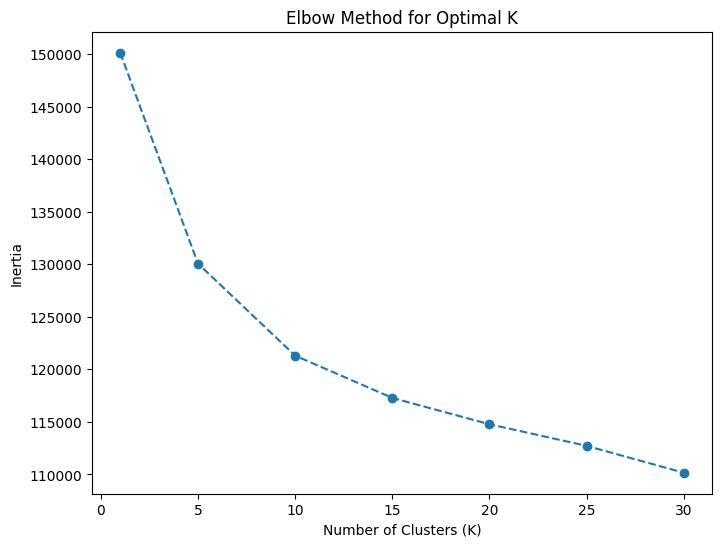

In [34]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

inertia = []
k_values = [1 ,5, 10 , 15  , 20 , 25 , 30] 
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(embeddings_matrix)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker="o", linestyle="--")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()


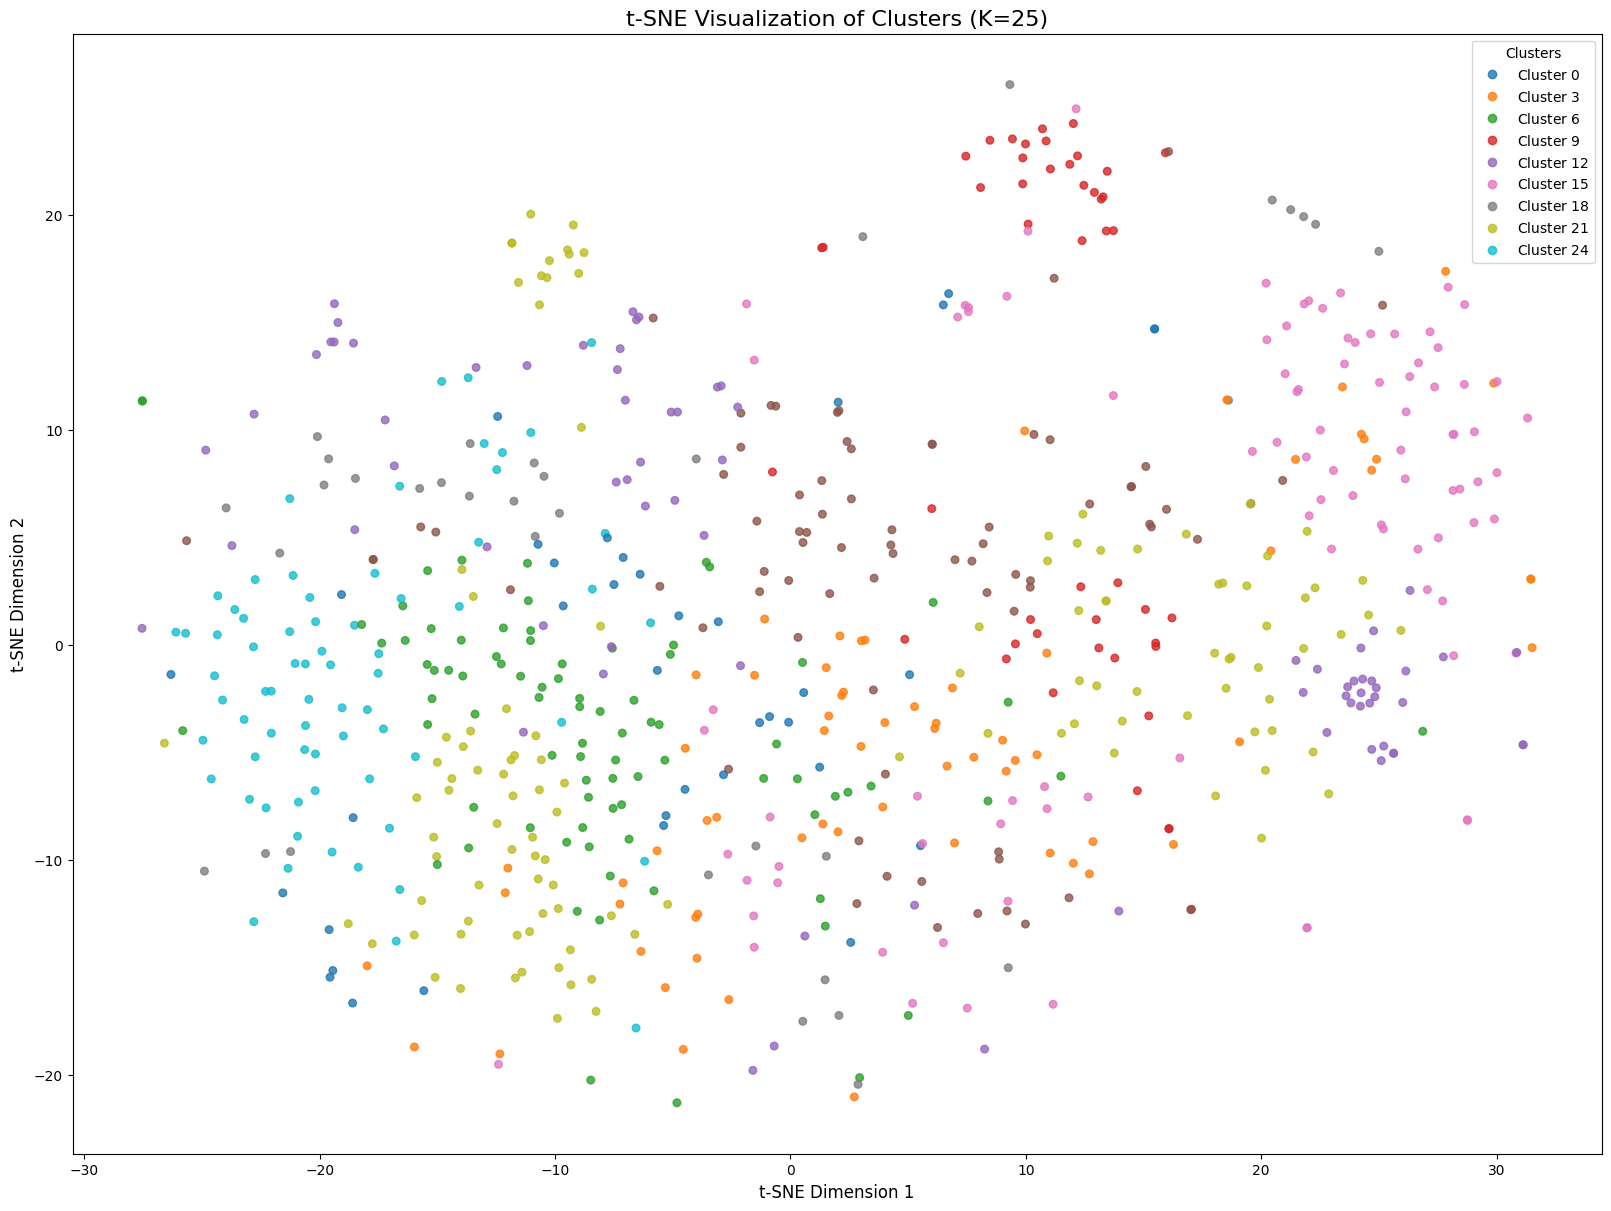

In [35]:
from matplotlib import cm
import matplotlib
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

optimal_k = 25
kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42)
data["cluster"] = kmeans.fit_predict(embeddings_matrix)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(embeddings_matrix)

fig, ax = plt.subplots(figsize=(16, 12), constrained_layout=True)

cmap = matplotlib.colormaps["tab10"]  
colors = [cmap(i / optimal_k) for i in range(optimal_k)]

scatter = ax.scatter(
    X_tsne[:, 0], 
    X_tsne[:, 1], 
    c=data["cluster"], 
    cmap=cm.colors.ListedColormap(colors), 
    s=30, 
    alpha=0.8
)

handles, labels = scatter.legend_elements()
labels = [f"Cluster {label}" for label in labels]
legend = ax.legend(handles, labels, title="Clusters", loc='best')

plt.title(f't-SNE Visualization of Clusters (K={optimal_k})', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

plt.show()


In [36]:
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}:")
    cluster_texts = data[data["cluster"] == cluster_id]["text"]
    print(cluster_texts.head(3).to_list())


Cluster 0:
['Вы твари суки что вы делаете то а уроды не русский питух вы зачем так жестоко с собаками обращаетесь неруси', 'Твари,горите а аду😮']

Cluster 1:
['ولاه يا ولدي القرعة تستنه فيك', 'الشهره اللي كانت عندك انت القديمه عند هذا وعند غيره واي واحد خنز بحالك', 'وين  راهي هد الطفلة زواجات ولا وين راحة وش احواله']

Cluster 2:


Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


['هدرتو كلها صحيحه انا رجالي كيدير فيزة هدرتو صحيحه لبنت هنا ديرين فضيحه والله وليت نحشم نقول انا من مغرب انا ورجالي', 'يجب حماية هشام وخاصك تخوي مدينة لي نتا فيها من الاحسن', 'حماية هشام حماية هشام حماية هشام <br>يا ربي تحميه ياااااااااا ربي حشووووووووومة هدشي لي كيطرا <br>رضى خصو😊الحبس و الذبيحة']

Cluster 3:
['Hada bayna fih rara9 o kdab', 'Mskin b9a fiya khyf lyxouf mn halo', '3afakom layrhm lwalidine li kay3rf chi tbib f agadir kaydir l ijhad idwi meaya']

Cluster 4:
['كتبيعوا العجل', 'ديما كنسول منين كيجيوه دوك الفلوس والدهوبات واش هادشي كامل من الاشهارات؟ ربما الان كلشي اتضح والله اعلم', 'دبا عاد عرفت علاش لمغربيات يدعمون ولد شينوية ومولينيكس حيت كان يبعتهم للخليج']

Cluster 5:
['❤❤😂😂']

Cluster 6:


['هادي راها خلية تجار بالبشر يجب ان يتم تحقيق مع ابن شنو ية باش يطيحو هذا شبكة', 'عصابة حمزة مون بيبي في حلة جديدة بإسم رضى مول دبي .<br>وافينكم يا الأمهات لتتصيفطو بناتكم للإمارات هانتوما سمعو  بغايتو الثراء ها الفضيحة بعينيها ، ياربي تعفووو', 'انا لبناني أطالب من جلاله الملك محمد السادس أطال الله في عمرة بحبس ابن الشنويه المؤبد في السجن']

Cluster 7:
['بقا فيا هد خينا باينة فيه دوز العداب الله يرد بيه و يهديه', 'حرام عليكم تحطو حياتو فخطر .ممكن يعيش حياتو كلها تهديد هدشي الى مقتلوهش', 'الله يعفو عليك وخلاص الشباب تابع تفاهات الخويا راه مسكين خايف من داك العصابة']

Cluster 8:
['والله حتى جاني لبكا', 'خاصو الحماية', 'هذا مو خاصو الاعدام']

Cluster 9:


['دادودية قارية الصحافة😂😂😂', 'Cette dame nous parle du droit au Maroc 😂😂😂', 'مابقاش تقول الحاجة اولدي الحاجات 😂😂😂😂😂']

Cluster 10:
['Polis: bravo', 'Malha ?', 'shof tv shoohha']

Cluster 11:
['كلب كم تبعوليا❤', 'أقل شئ ١٥ سنة سجن', 'الله يعز المخزن.خاص مو الفران هذ المكروبات البشرية العافية.']

Cluster 12:


['حسبي الله ونعم الوكيل ھد الناس مديرينش بحساب لقاء الله', 'توبوا إلى الله <br>لا تتبعوا الشهوة  هي شهوة زاءلة  <br>حتى المال  فتنة', 'العز للرجولة الله اعزك اخويا']

Cluster 13:
['🙀🙀🙀🙀🙀', 'الله الوطن الملك', 'الله يهديهم']

Cluster 14:


['الحرية للصحافي للمهداوي', 'علامة الساعة .الشوها.العالمية اين المسؤولين.؟؟؟؟', 'القضية  حامضة']

Cluster 15:
['😢😢😢😢miskne', 'Warah galha monenex fach kan m3ti m3ah', 'Maddah.masskin.kan.victim......bab.attaouba.maftouh.tab.ila...allah.allay.yahfado.']

Cluster 16:


['Kolna hicham lmdah', 'Hadok lbnat lidaklo marad lablad', 'Manin jab rida lflos kas lbnat lidaklin man karij yadiro kontrol yadiro lihom kontrol fe sabitar ydiro lihom tahlil']

Cluster 17:
['هادا بحال محمد السادس 😅', 'Ouled chinwiyats sont nombreux aux Maroc, ils exercent leurs sordides activités avec la complicité des fonctionnaires de l&#39;état 😢', 'هاد الشاب باين عليه انسان ضريف ومسالم مسكين ومكافح وكيتكلم بنية صافية ،تحياتي ليك أولدي 🤲🤲💕']

Cluster 18:


['Walh hat samira wa3ra katgolo 3ayati maskin hak hak tarmilo silh lahmi hahahaha😅😅😅', 'Hahaha walh hat had sida chof tv wa3ra fa gajam katgol baz lik nari tanfkhali ras awli awli maskin darbo silh lahmi hadk kaygar', 'Baktrat lma bazf bandam maskin fih khof ga3 li daz man lma dayl sofia kaydkhlo khof maskin chadto ra3da hit tab tasdam']

Cluster 19:
['هههههه صحاب الصحابة الفاشلة', 'مسكين مخلوع عندك غير يديرو ليه شي فضيحة', 'خادي نخرج عن الموضوع  عطو لسييد كرسي مريح شوية ساعة و هو جالس يتكلم  على اعصابو و كملتو عليه طبيسل لي جالس عليه الله يعينك']

Cluster 20:


['اش هاذ الخرا من المديعة للضيف الكمرا مان للمشاهد كلكولشي 😂😂😂', 'لازم حماية هشام.وهادشي خاصو يحبس وسخو بلادنا بزاااف', 'كما قال الشاعر المغربي &quot;لي عطى زكو لهلا يفكو&quot; المغاربة اللخر يطفي ضوو غادا وتتقواد فهاد لبلاد عيش نهار تسمع خبار &quot;الله يدينا فضو&quot;']

Cluster 21:
['Hadchi khatiiiiiir la hawla wala kowata illa billah', 'لا حول ولا قوة إلا بالله', 'أستغفر الله ولا حول ولا قوة الا بالله وأتوب اليه']

Cluster 22:
['شوهتونا باركة من هاذ البرامج', 'Chouha tv chawahtou bina', 'سير ديها في راسك البنات هما بغات']

Cluster 23:
['و هكذا انتهت القصة ؛فمنصة المحاكم ليست كمنصة التواصل الإجتماعي 😅😅😅', 'مسكين المداح كيقول الحقيقة وخايف كلنا هشام وسميرة خلاتو يحس بالأمان بكلامها شكرا سميرة', 'يجب على الأمن ان يحمي هشام بعد اخد شهادته ضد بائع لحم البشر ولد الشينوية وجماعته']

Cluster 24:
['الحرام هذا آخره<br>لازم يتعاقب حتى الوالدين لي كي يسيفطوا بناتهم ويشوهوا بالبلاد', 'يجب حماية هذآ الشاب لأنه يتلقى تهديدات وضغوطات ،الله يحفضو مسكين 🙄🤲❤️', 'حت هادا خاصو امشي يتربا علاش بقا ساكت 

In [37]:
data.to_csv("/kaggle/working/clustered_data.csv")